In [1]:
renv::init('/oak/stanford/groups/agitler/Shared/Shared_Jupyter_Notebook_Analysis/4.1.1-OG/')

In [2]:
library(dplyr)
library(Seurat)
library(ggplot2)
library(ggrepel)
library(ComplexHeatmap)
library(gplots)
library(ggrastr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching SeuratObject

Loading required package: grid

ComplexHeatmap version 2.10.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))



Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess




## Save Directories for Figs + Tables

In [3]:
fig_dir <- '/oak/stanford/groups/agitler/Shared/Matters_Arising/Figure_Panels/Reviews'
csv_dir <- '/oak/stanford/groups/agitler/Shared/Matters_Arising/CSV_Files'

## Custom Function

### Volcano plot

In [4]:
make_volcano_plot <- function(data, labeled_pts, labeled_genes=c(), p_val_cutoff=0.05, title, ylimits=NULL, xlimits=NULL, upper_log2FC_cutoff=0, lower_log2FC_cutoff=0, values = c("dodgerblue3", "gray50", "firebrick3")) {
    data <- data %>% 
    mutate(
        Expression = case_when(avg_log2FC >= upper_log2FC_cutoff & p_val_adj <= p_val_cutoff ~ "Up-regulated",
                           avg_log2FC <= lower_log2FC_cutoff & p_val_adj <= p_val_cutoff ~ "Down-regulated",
                           TRUE ~ "Unchanged")
    )


    top <- labeled_pts
   
    top_genes <- bind_rows(
      data %>% 
        filter(Expression == 'Up-regulated') %>% 
        arrange(p_val_adj, desc(abs(avg_log2FC))) %>% 
        head(top),
      data %>% 
        filter(Expression == 'Down-regulated') %>% 
        arrange(p_val_adj, desc(abs(avg_log2FC))) %>% 
        head(top),
      data %>% 
        filter(gene %in% labeled_genes)
    )
    

    x_scale <- max(abs(data$avg_log2FC))
    
    p1 <- ggplot(data, aes(avg_log2FC, -log(p_val_adj,10))) + # -log10 conversion 
        labs(title = title) +
        geom_point(aes(color = Expression), size = 8/5) +
        geom_label_repel(data = top_genes, mapping = aes(avg_log2FC, -log(p_val_adj,10), label = gene),
                        size = 4, max.overlaps=18)+
        xlim(-x_scale,x_scale)+
        xlab(expression("Avg. log"[2]*"FC")) + 
        ylab(expression("-log"[10]*"(p adj)")) + 
        scale_color_manual(values = values) + 
        guides(colour = guide_legend(override.aes = list(size=1.5)))  + 
        scale_y_continuous(limits = ylimits) +
        scale_x_continuous(limits = xlimits) +
        theme_classic() +
        theme(axis.text = element_text(size = 15), axis.title = element_text(size = 15), plot.title = element_text(size = 18, face = "bold", hjust = 0.5))     
p1  
}

## Load data

In [5]:
gautier_neurons <- readRDS('/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/gautier_neurons.rds')
yadav_neurons <- readRDS(file = '/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/yadav_neurons.rds')

### ALS and cytoskeletal genes

In [6]:
als_cytoskeletal_genes <- c("NEFH", "OPTN", "PRPH", "SOD1", "STMN2", "TUBA4A", "CHCHD10", "KIF5A", "SPP1", "NEFL", "NEFM", "SNCG", "TMSB4X", "TUBA1B", "TUBA1A", "ACTG1", "TUBB4B", "UBB", "DYNC1H1", "YWHAG", "KIF21A", "TUBB2A", "KLC1", "MAP1B", "ACTB")

## Differential expression analysis with Gautier dataset

In [7]:
Idents(gautier_neurons) <- gautier_neurons$motor_neuron
gautier_mn_markers <- FindMarkers(gautier_neurons, ident.1 = "Motor Neurons", ident.2 = "Other Neurons", logfc.threshold=0, min.pct=0, max.cells.per.ident = 40)

In [8]:
gautier_mn_markers$gene <- rownames(gautier_mn_markers)
rownames(gautier_mn_markers) <- NULL

In [9]:
gautier_als_cytoskeletal <- dplyr::filter(gautier_mn_markers, gene %in% als_cytoskeletal_genes)
gautier_als_cytoskeletal$p_val_adj = p.adjust(gautier_als_cytoskeletal$p_val, method='bonferroni')

### Figure S1O

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.



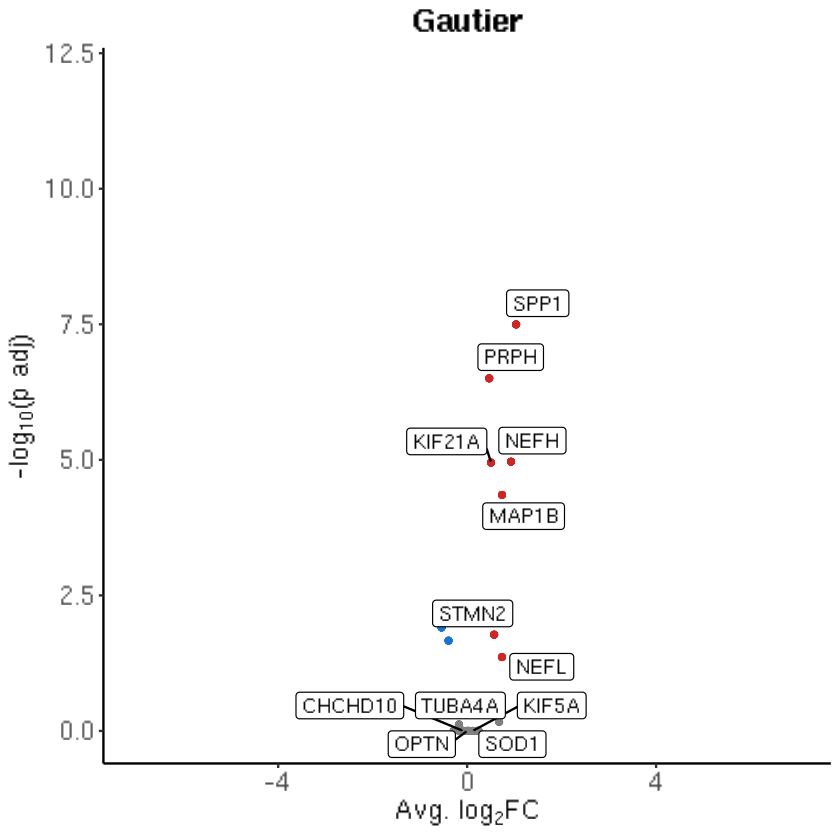

In [10]:
gautier_als_cytoskeletal_volcano_plot <- make_volcano_plot(gautier_als_cytoskeletal, 0, labeled_genes = c("NEFH","OPTN","PRPH","SOD1","STMN2","TUBA4A","SPP1","NEFL","KIF21A","MAP1B","CHCHD10","KIF5A"), title = "Gautier", ylimits = c(0,12), xlimits = c(-7,7)) 
gautier_als_cytoskeletal_volcano_plot <- rasterize(gautier_als_cytoskeletal_volcano_plot, layers="Point", dpi=500) + NoLegend()
gautier_als_cytoskeletal_volcano_plot

In [11]:
ggsave(gautier_als_cytoskeletal_volcano_plot, filename = paste(fig_dir, 'gautier_als_cytoskeletal_volcano_plot.svg', sep='/'),device='svg', width = 5.4834, height = 3.353, units = "in")

In [12]:
rownames(gautier_als_cytoskeletal) <- gautier_als_cytoskeletal$gene
gautier_als_cytoskeletal <- dplyr::select(gautier_als_cytoskeletal, -gene)

In [13]:
gautier_als_cytoskeletal

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SPP1,1.271378e-09,1.037609329,0.850,0.300,3.178446e-08
PRPH,1.254566e-08,0.467828586,0.600,0.009,3.136414e-07
NEFH,4.326643e-07,0.928255665,1.000,0.535,1.081661e-05
KIF21A,4.487929e-07,0.505977104,1.000,0.994,1.121982e-05
MAP1B,1.774232e-06,0.738470533,1.000,0.996,4.435581e-05
UBB,4.938663e-04,-0.542604360,0.925,0.860,1.234666e-02
STMN2,6.700356e-04,0.572039665,1.000,0.980,1.675089e-02
ACTB,8.652630e-04,-0.394341912,0.875,0.850,2.163158e-02
NEFL,1.734374e-03,0.737661144,1.000,0.842,4.335934e-02


### Table S1C (related to Figure S1O)

In [14]:
write.csv(gautier_als_cytoskeletal, file=paste(csv_dir, 'Reviews/Table S1C.csv', sep='/'))

## Differential expression analysis with Yadav dataset

In [15]:
Idents(yadav_neurons) <- yadav_neurons$motor_neuron
yadav_mn_markers <- FindMarkers(yadav_neurons, ident.1 = "Motor Neurons", ident.2 = "Other Neurons", logfc.threshold=0, min.pct=0, max.cells.per.ident = 40)

In [16]:
yadav_mn_markers$gene <- rownames(yadav_mn_markers)
rownames(yadav_mn_markers) <- NULL

In [17]:
yadav_als_cytoskeletal <- dplyr::filter(yadav_mn_markers, gene %in% als_cytoskeletal_genes)
yadav_als_cytoskeletal$p_val_adj = p.adjust(yadav_als_cytoskeletal$p_val, method='bonferroni')

### Figure S1P

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.



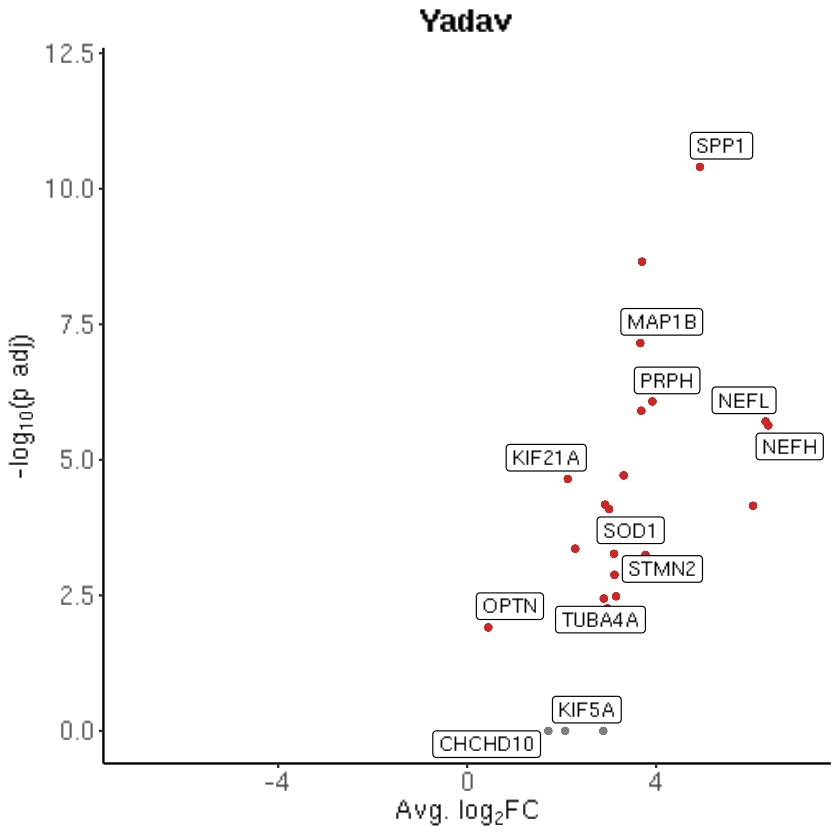

In [18]:
yadav_als_cytoskeletal_volcano_plot <- make_volcano_plot(yadav_als_cytoskeletal, 0, labeled_genes = c("NEFH","OPTN","PRPH","SOD1","STMN2","TUBA4A","SPP1","NEFL","KIF21A","MAP1B","CHCHD10","KIF5A"), title = "Yadav", ylimits = c(0,12), xlimits = c(-7,7), values = c("gray50", "firebrick3")) 
yadav_als_cytoskeletal_volcano_plot <- rasterize(yadav_als_cytoskeletal_volcano_plot, layers="Point", dpi=500) + NoLegend()
yadav_als_cytoskeletal_volcano_plot

In [19]:
ggsave(yadav_als_cytoskeletal_volcano_plot, filename = paste(fig_dir, 'yadav_als_cytoskeletal_volcano_plot.svg', sep='/'),device='svg', width = 5.4834, height = 3.353, units = "in")

In [20]:
rownames(yadav_als_cytoskeletal) <- yadav_als_cytoskeletal$gene
yadav_als_cytoskeletal <- dplyr::select(yadav_als_cytoskeletal, -gene)

In [21]:
yadav_als_cytoskeletal

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SPP1,1.582270e-12,4.9286215,0.943,0.676,3.955675e-11
TUBA1A,8.854419e-11,3.7019377,0.862,0.750,2.213605e-09
MAP1B,2.805483e-09,3.6640944,0.914,0.947,7.013707e-08
PRPH,3.354635e-08,3.9207108,0.648,0.043,8.386587e-07
ACTG1,4.966641e-08,3.6868615,0.794,0.619,1.241660e-06
NEFL,7.838398e-08,6.3181092,0.819,0.580,1.959599e-06
NEFH,9.258670e-08,6.3746662,0.803,0.459,2.314667e-06
ACTB,7.746702e-07,3.3135486,0.826,0.743,1.936675e-05
KIF21A,9.004658e-07,2.1312771,0.764,0.902,2.251165e-05


### Table S1D (related to Figure S1P)

In [22]:
write.csv(yadav_als_cytoskeletal, file=paste(csv_dir, 'Reviews/Table S1D.csv', sep='/'))

## ALS and cytoskeletal gene enrichment box plots

In [23]:
gautier_als_cytoskeletal$study <- "Gautier"
yadav_als_cytoskeletal$study <- "Yadav"
als_cytoskeletal <- dplyr::bind_rows(gautier_als_cytoskeletal, yadav_als_cytoskeletal)

### Figure S1Q

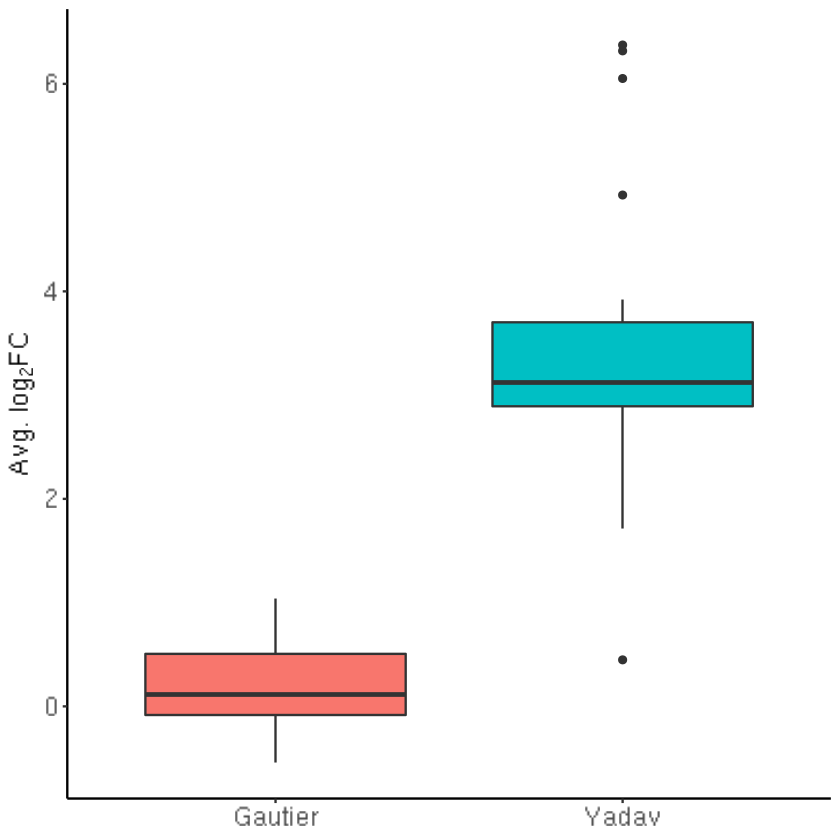

In [24]:
als_cytoskeletal_boxplot <- ggplot(als_cytoskeletal, aes(study, avg_log2FC, fill = study)) + geom_boxplot() +
  labs(y = expression("Avg. log"[2]*"FC")) + theme_classic() + 
  theme(axis.title.x = element_blank(), legend.position="none", axis.text = element_text(size = 15), axis.title = element_text(size = 15))

als_cytoskeletal_boxplot

In [25]:
ggsave(als_cytoskeletal_boxplot, filename = paste(fig_dir, 'als_cytoskeletal_boxplot.svg', sep='/'), device='svg', width = 1.9, height = 3.0689, units = "in")